Loaded Zachary's Karate Club graph
Nodes: 34, Edges: 78
Iteration 0: 1 communities


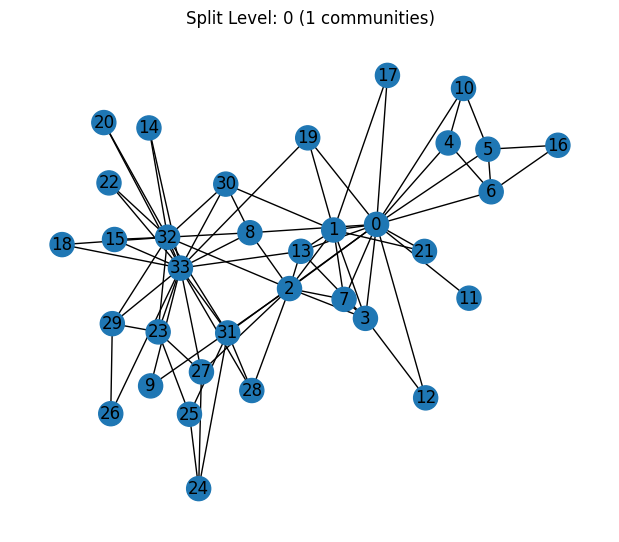

Iteration 1: 2 communities


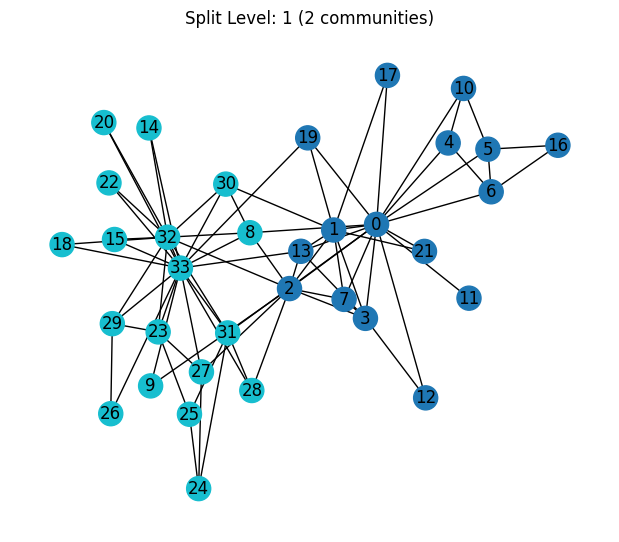

Iteration 2: 3 communities


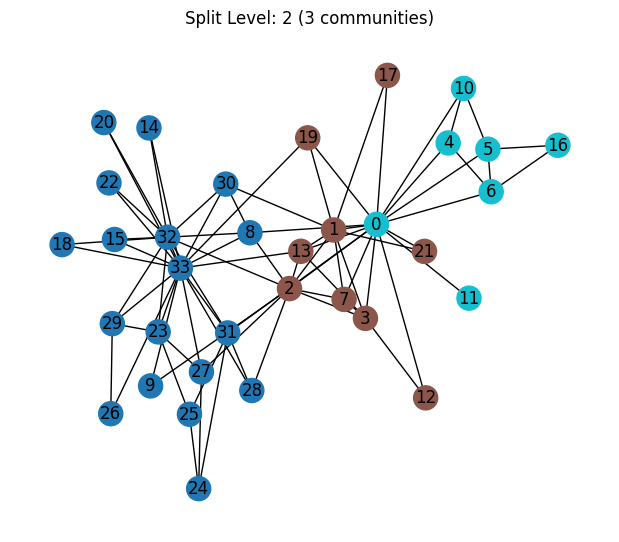

Iteration 3: 4 communities


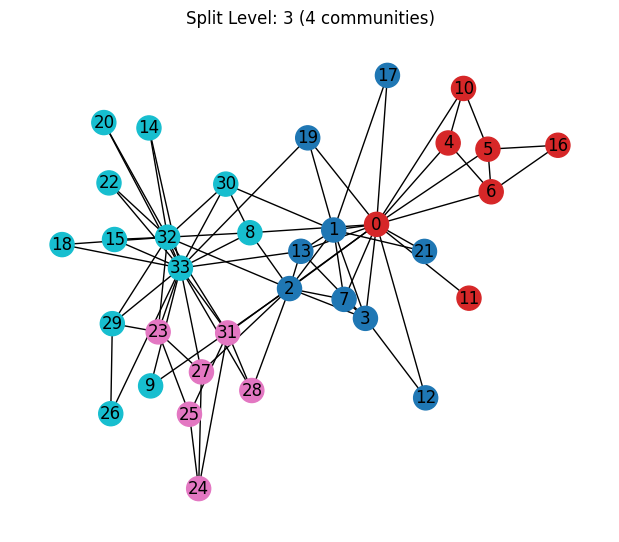


Identified 4 clusters

0.4210940574576938
Communities:
  Community 0: {1, 2, 3, 7, 12, 13, 17, 19, 21}
  Community 1: {0, 4, 5, 6, 10, 11, 16}
  Community 2: {23, 24, 25, 27, 28, 31}
  Community 3: {32, 33, 8, 9, 14, 15, 18, 20, 22, 26, 29, 30}


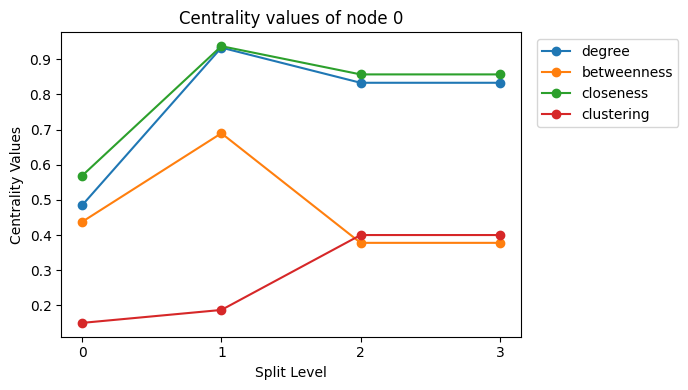

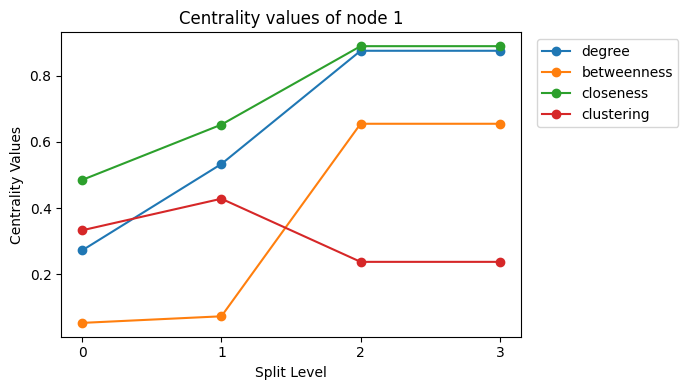

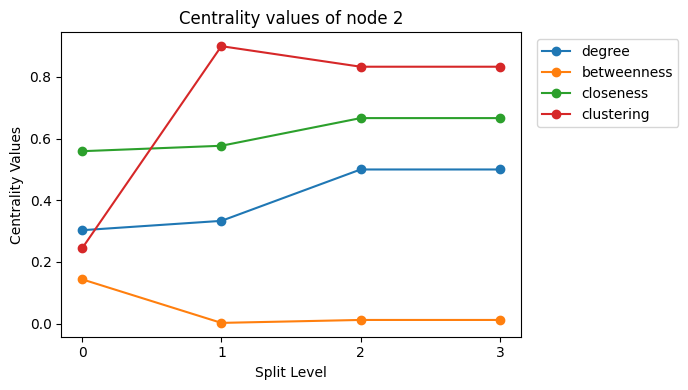

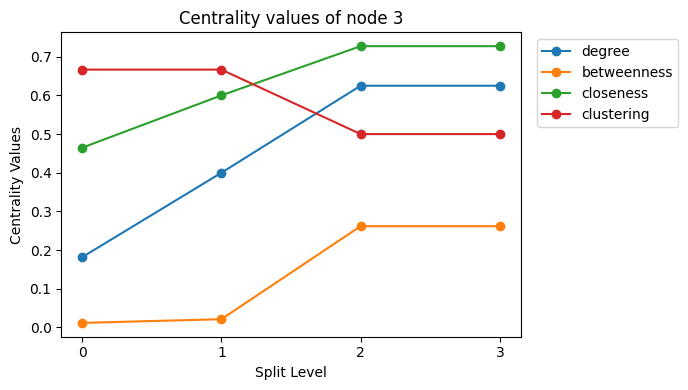

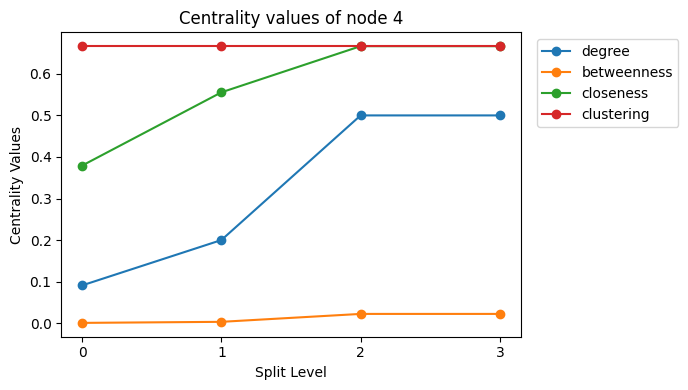

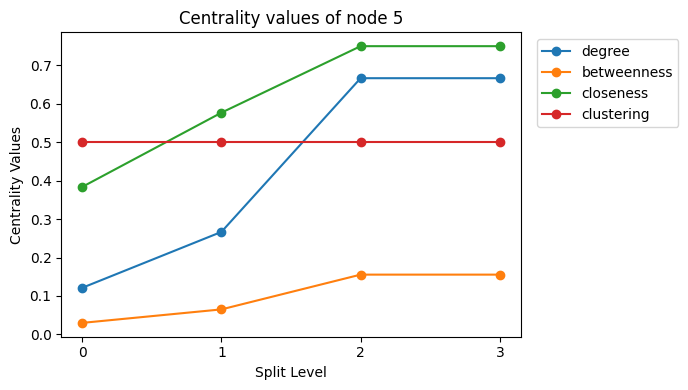

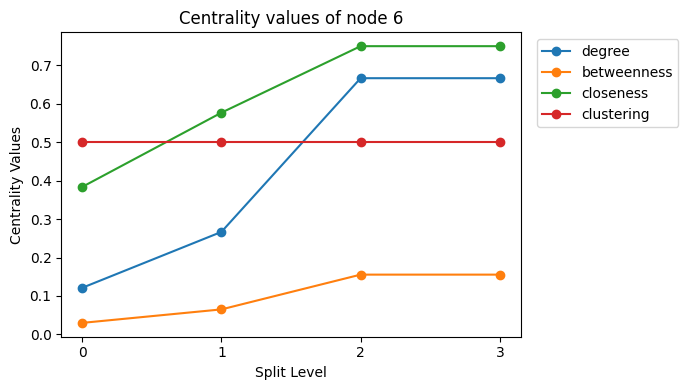

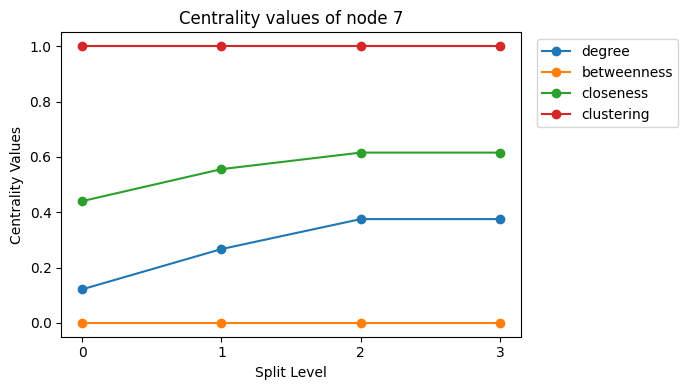

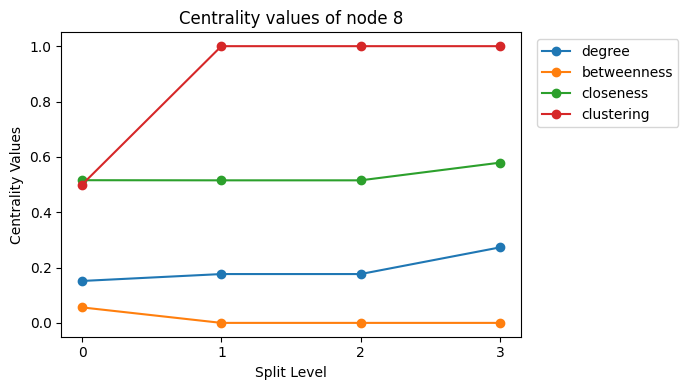

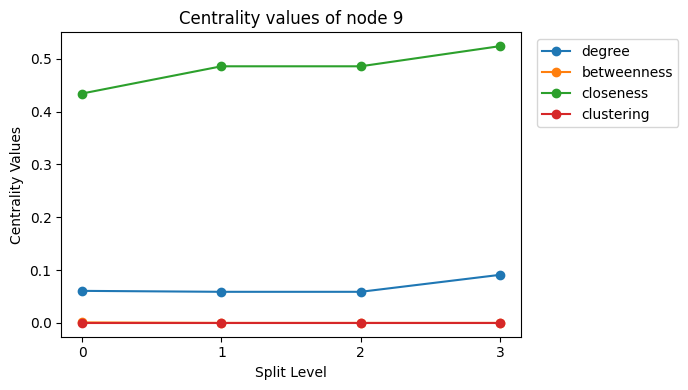

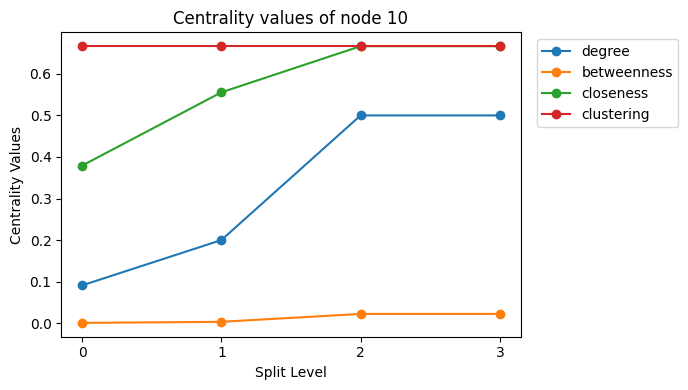

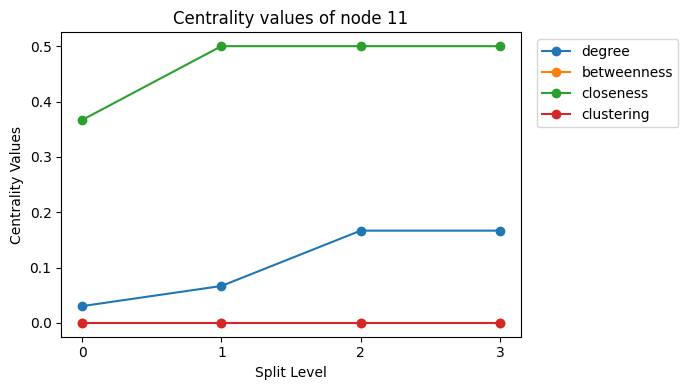

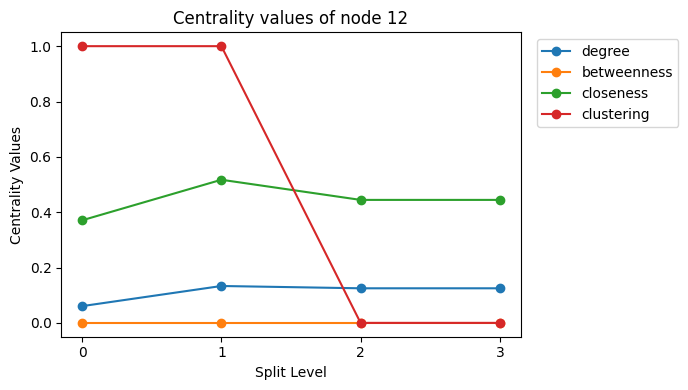

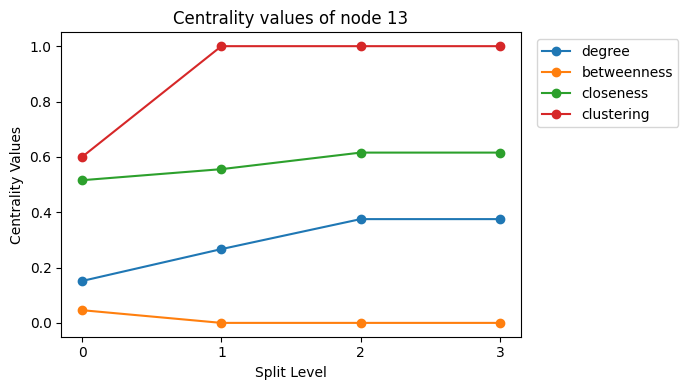

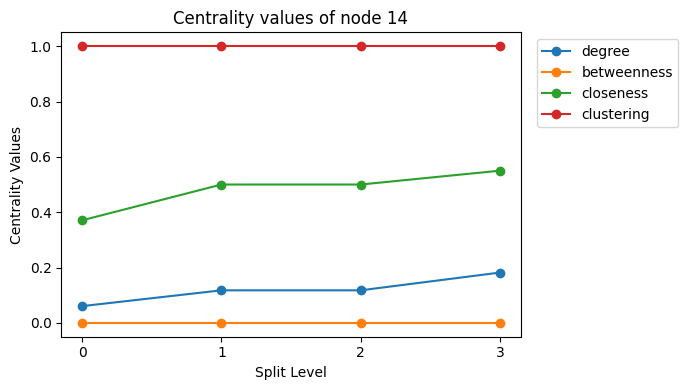

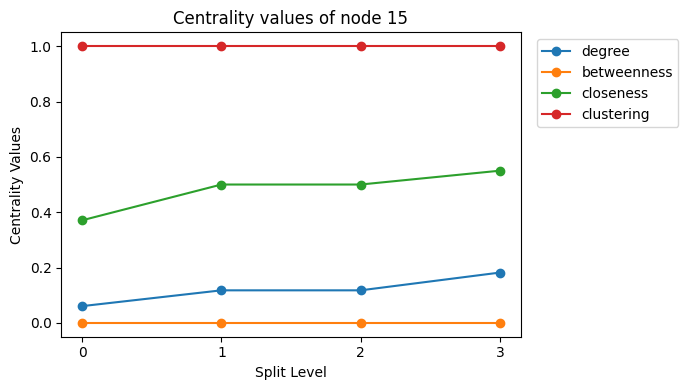

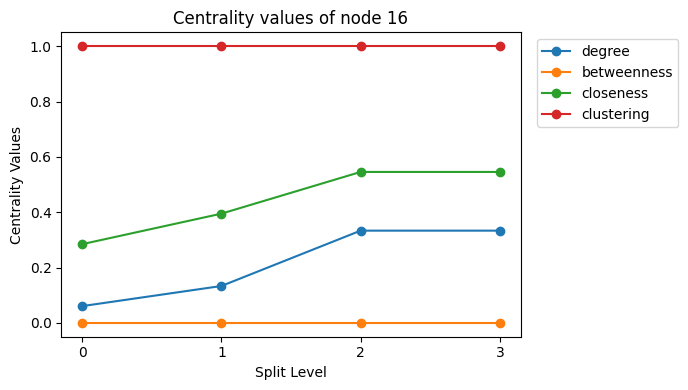

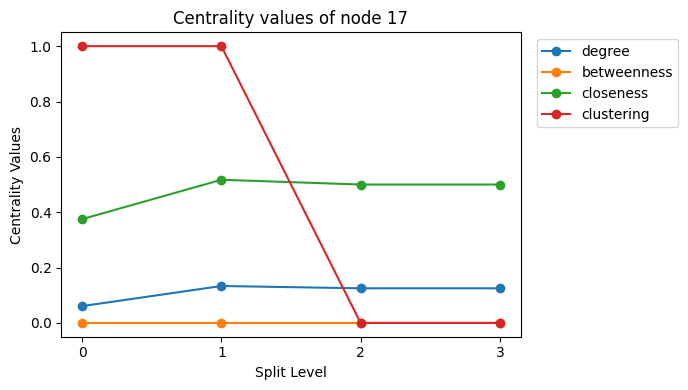

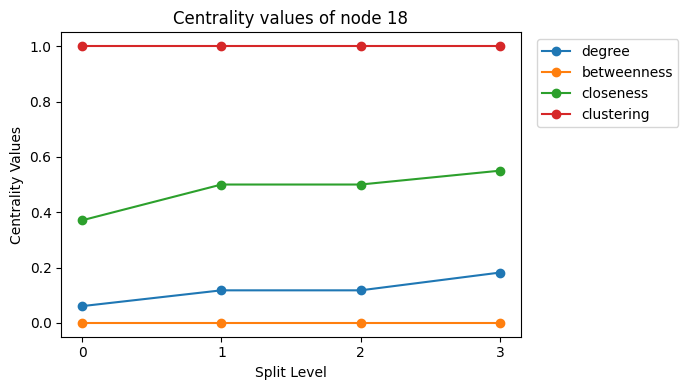

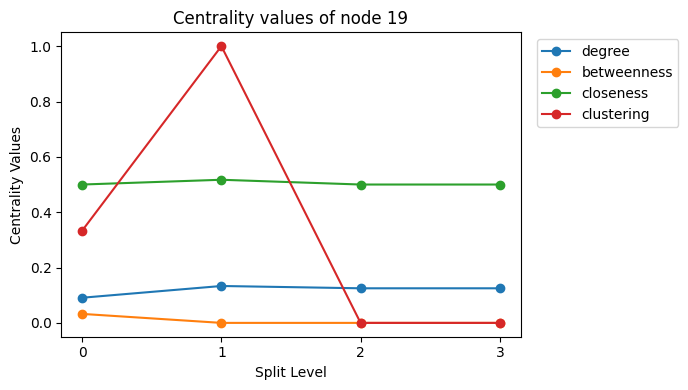

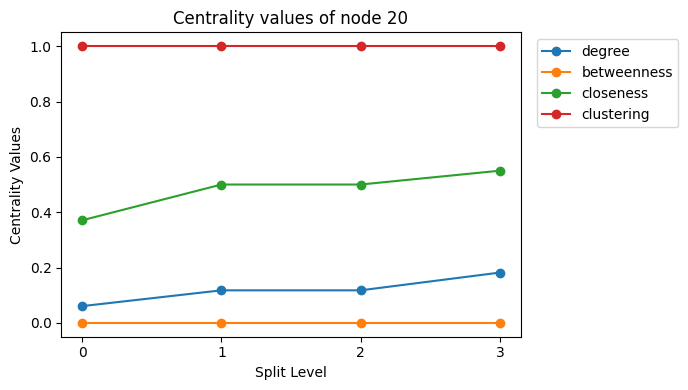

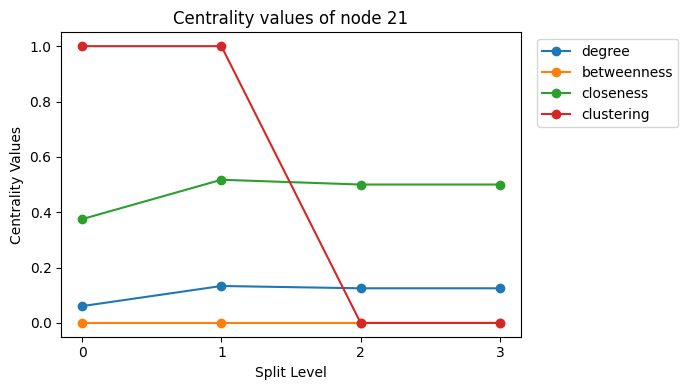

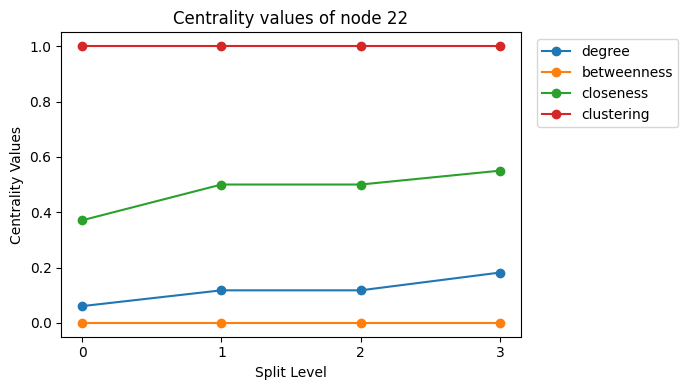

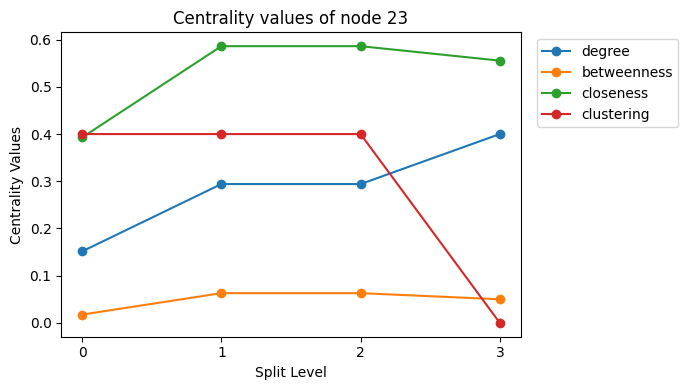

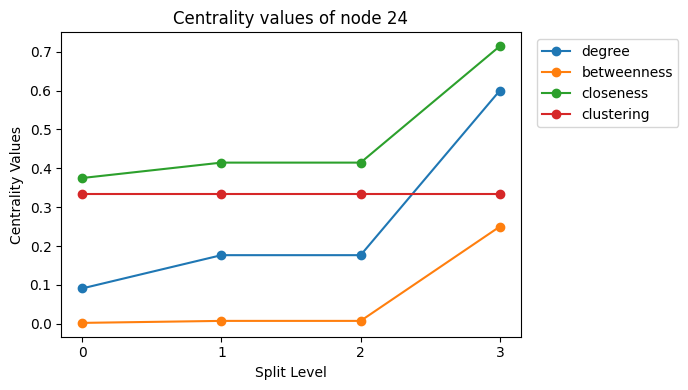

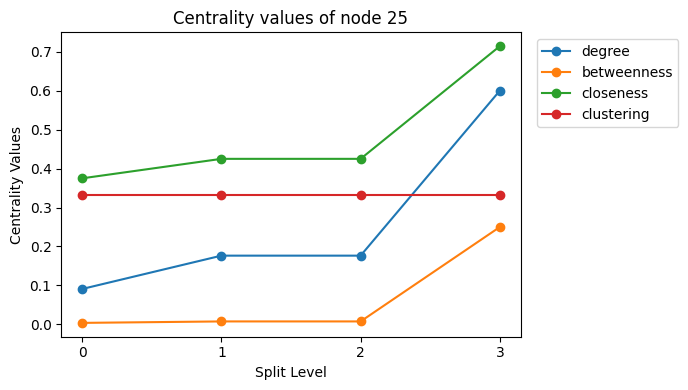

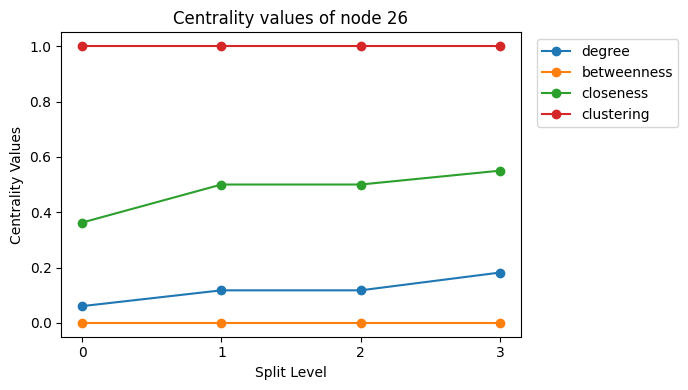

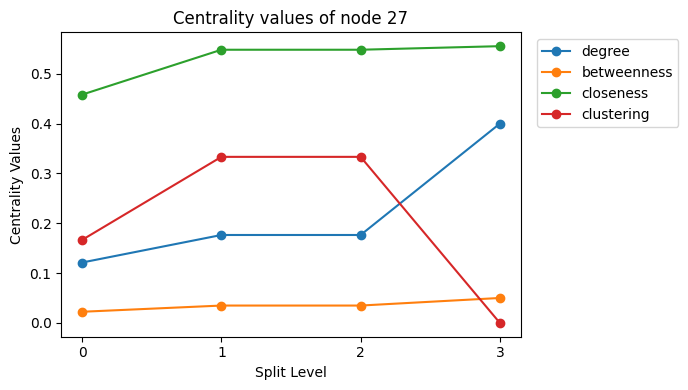

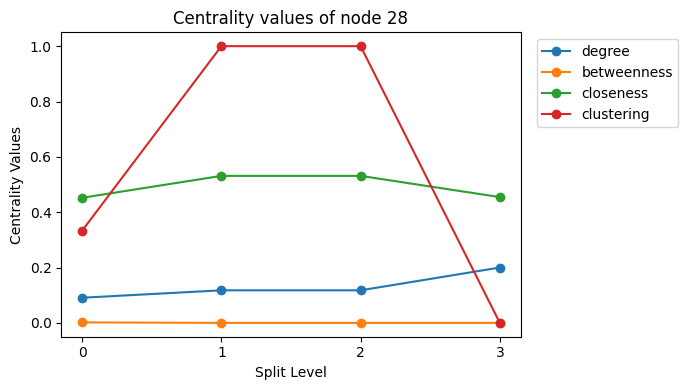

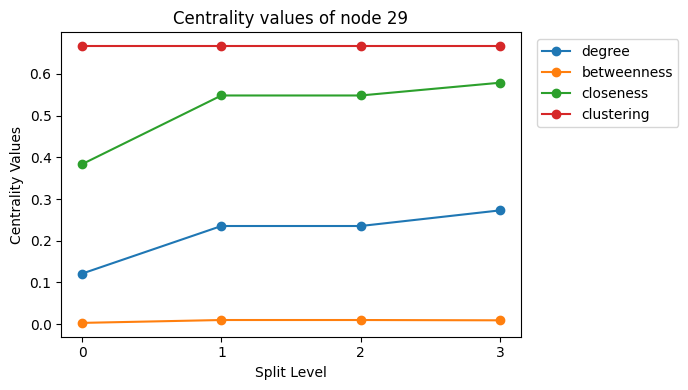

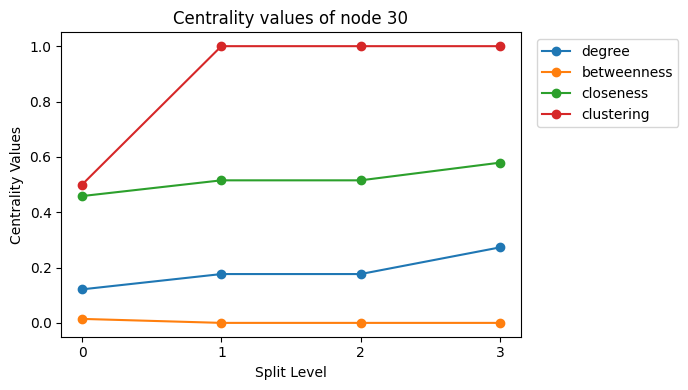

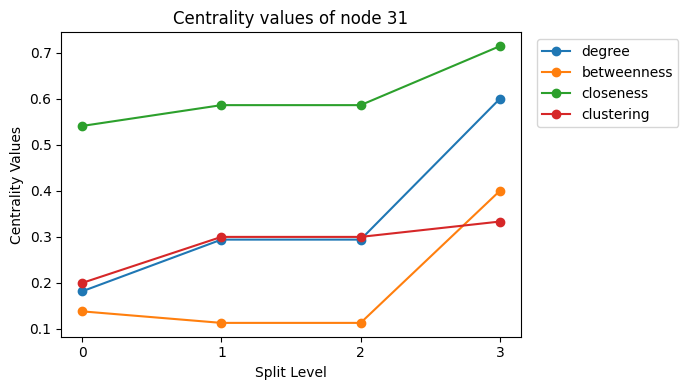

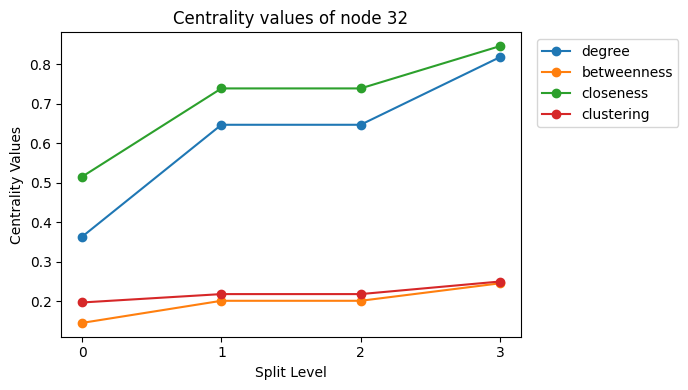

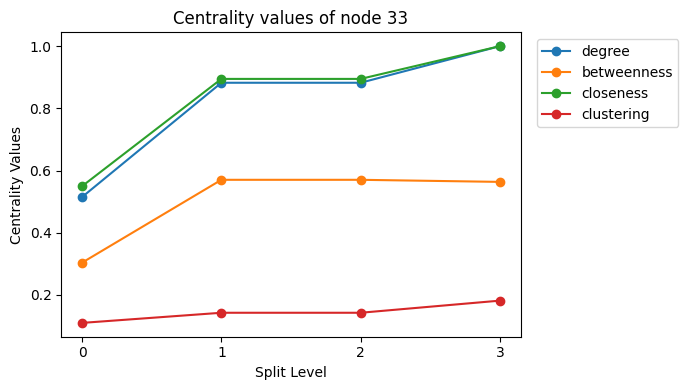

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.community import modularity
from typing import List, Optional, Tuple, Dict, Set


def try_split(G: nx.Graph, node_list: List[int], tol: float = 1e-10
              ) -> Optional[Tuple[List[int], List[int]]]:
    """
    Attempt to split the induced subgraph on `node_list` using the leading
    eigenvector of the modularity submatrix. Returns two lists of nodes
    if a valid split exists, otherwise None.
    """
    if len(node_list) <= 1:
        return None

    subgraph = G.subgraph(node_list)
    adj_matrix = nx.to_numpy_array(subgraph, nodelist=node_list)
    degree_seq = np.sum(adj_matrix, axis=1)
    m_edges = degree_seq.sum() / 2.0
    if m_edges == 0:
        return None

    modularity_sub = adj_matrix - np.outer(degree_seq, degree_seq) / (2.0 * m_edges)

    try:
        eigenvals, eigenvecs = np.linalg.eigh(modularity_sub)
    except np.linalg.LinAlgError:
        return None

    leading_eigval = eigenvals[-1]
    if leading_eigval <= tol:
        return None

    leading_eigvec = eigenvecs[:, -1]
    group_positive, group_negative = [], []
    for idx, node in enumerate(node_list):
        if leading_eigvec[idx] > 0:
            group_positive.append(node)
        else:
            group_negative.append(node)

    if not group_positive or not group_negative:
        return None

    return group_positive, group_negative


def get_metrics(G: nx.Graph, communities: List[Set[int]]
                ) -> Tuple[Dict[int, float], Dict[int, float], Dict[int, float], Dict[int, float]]:
    """
    Compute degree centrality, betweenness centrality, closeness centrality
    and local clustering coefficient for each node with respect to its community's subgraph.
    Returns four dicts keyed by node.
    """
    node_to_comm: Dict[int, Set[int]] = {}
    for comm in communities:
        for n in comm:
            node_to_comm[n] = comm

    deg_cent: Dict[int, float] = {}
    bet_cent: Dict[int, float] = {}
    clo_cent: Dict[int, float] = {}
    cluster_coeff: Dict[int, float] = {}

    for n in G.nodes():
        comm = node_to_comm.get(n, {n})
        sg = G.subgraph(comm)
        if sg.number_of_nodes() > 1:
            deg = nx.degree_centrality(sg).get(n, 0.0)
            bet = nx.betweenness_centrality(sg, normalized=True).get(n, 0.0)
            clo = nx.closeness_centrality(sg).get(n, 0.0)
        else:
            deg = bet = clo = 0.0

        deg_cent[n] = deg
        bet_cent[n] = bet
        clo_cent[n] = clo
        cluster_coeff[n] = nx.clustering(sg).get(n, 0.0)

    return deg_cent, bet_cent, clo_cent, cluster_coeff


def plot_state(G: nx.Graph, layout_pos: Dict[int, Tuple[float, float]],
               communities: List[Set[int]], iteration: int, show: bool = True) -> None:
    """Plot graph with nodes colored per community."""
    print(f'Iteration {iteration}: {len(communities)} communities')
    color_map: Dict[int, int] = {}
    for i, comm in enumerate(communities):
        for n in comm:
            color_map[n] = i
    colors = [color_map[n] for n in G.nodes()]

    plt.figure(figsize=(6, 5))
    nx.draw(G, layout_pos, with_labels=True, node_color=colors, cmap=plt.cm.tab10, node_size=300)
    plt.title(f"Split Level: {iteration} ({len(communities)} communities)")
    if show:
        plt.show()
    else:
        plt.close()


def plot_metrics(history: List[Tuple[Dict[int, float], Dict[int, float],
                                     Dict[int, float], Dict[int, float]]],
                 num_nodes: int, show: bool = True) -> None:
    """Plot centrality metric evolution for each node across iterations."""
    n_iters = len(history)
    x_axis = list(range(n_iters))

    # Prepare history per node
    deg_hist = {n: [] for n in range(num_nodes)}
    bet_hist = {n: [] for n in range(num_nodes)}
    clo_hist = {n: [] for n in range(num_nodes)}
    clu_hist = {n: [] for n in range(num_nodes)}

    for deg_d, bet_b, clo_c, clu_l in history:
        for i in range(num_nodes):
            deg_hist[i].append(deg_d.get(i, 0.0))
            bet_hist[i].append(bet_b.get(i, 0.0))
            clo_hist[i].append(clo_c.get(i, 0.0))
            clu_hist[i].append(clu_l.get(i, 0.0))

    for i in range(num_nodes):
        plt.figure(figsize=(7, 4))
        plt.plot(x_axis, deg_hist[i], marker='o', label='degree')
        plt.plot(x_axis, bet_hist[i], marker='o', label='betweenness')
        plt.plot(x_axis, clo_hist[i], marker='o', label='closeness')
        plt.plot(x_axis, clu_hist[i], marker='o', label='clustering')
        plt.xticks(x_axis)
        plt.title(f'Centrality values of node {i}')
        plt.xlabel('Split Level')
        plt.ylabel('Centrality Values')
        plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
        plt.tight_layout()
        if show:
            plt.show()
        else:
            plt.close()


def main(show_plots: bool = True, max_clusters: Optional[int] = None) -> None:
    """Run recursive spectral modularity bisection on Zachary's Karate Club."""
    G = nx.karate_club_graph()
    num_nodes = G.number_of_nodes()
    layout_pos = nx.spring_layout(G, seed=4)

    print("Loaded Zachary's Karate Club graph")
    print(f"Nodes: {num_nodes}, Edges: {G.number_of_edges()}")

    history: List[Tuple[Dict[int, float], Dict[int, float], Dict[int, float], Dict[int, float]]] = []
    iteration = 0
    communities: List[Set[int]] = [set(G.nodes())]
    history.append(get_metrics(G, communities))
    plot_state(G, layout_pos, communities, iteration, show=show_plots)

    split_queue: List[List[int]] = [list(G.nodes())]
    final_partitions: List[List[int]] = []
    current_modularity = modularity(G, [set(split_queue[0])])

    while split_queue:
        current_nodes = split_queue.pop(0)
        split_res = try_split(G, current_nodes)
        if split_res is None:
            final_partitions.append(current_nodes)
            continue

        part_a, part_b = split_res

        # Prepare candidate partition list and test modularity
        candidate_partitions = [set(c) for c in final_partitions + split_queue]
        candidate_partitions.append(set(part_a))
        candidate_partitions.append(set(part_b))
        new_modularity = modularity(G, candidate_partitions)

        if new_modularity > current_modularity:
            # Check max_clusters constraint
            if max_clusters is not None and (len(final_partitions) + len(split_queue) + 1) >= max_clusters:
                final_partitions.append(current_nodes)
                continue

            current_modularity = new_modularity
            split_queue.append(part_a)
            split_queue.append(part_b)
            iteration += 1
            all_communities = [set(c) for c in final_partitions + split_queue]
            plot_state(G, layout_pos, all_communities, iteration, show=show_plots)
            history.append(get_metrics(G, all_communities))
        else:
            final_partitions.append(current_nodes)

    final_communities = [set(c) for c in final_partitions]
    print(f'\nIdentified {len(final_communities)} clusters\n')
    print(modularity(G, final_communities))
    print("Communities:")
    for i, comm in enumerate(final_communities):
        print(f"  Community {i}: {comm}")

    if show_plots:
        plot_metrics(history, num_nodes, show=show_plots)


if __name__ == "__main__":
    main(show_plots=True, max_clusters=None)
